In [1]:
#https://www.kaggle.com/datasets/sartajbhuvaji/brain-tumor-classification-mri/data?select=Training

In [2]:
import pandas as pd
import numpy as np
import glob

import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from keras.layers import Input,Dense,Flatten,MaxPooling2D
from keras.models import Model

from keras.applications.vgg19 import VGG19,preprocess_input

from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image

from keras.models import Sequential
from tensorflow.keras import metrics

import os

from IPython.display import display
from IPython.display import Image as _Imdis

In [3]:
##  upload the kaggle.json file before running this cell

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [4]:
# downloading the dataset from kaggle

!kaggle datasets download -d sartajbhuvaji/brain-tumor-classification-mri

100% 86.8M/86.8M [00:03<00:00, 37.3MB/s]
100% 86.8M/86.8M [00:03<00:00, 29.7MB/s]


In [5]:
# lets unzip the file which is downloaded from kaggle

from zipfile import ZipFile

dataset = "/content/brain-tumor-classification-mri.zip"

with ZipFile(dataset,"r") as zip:
  zip.extractall()
  print("Brain Tumor Dataset has been Extracted")

Brain Tumor Dataset has been Extracted


In [6]:
# setting up the train and test path

train_path = "/content/train"
test_path = "/content/test"

working with ['gg (85).jpg', 'gg (357).jpg', 'gg (466).jpg', 'gg (682).jpg', 'gg (224).jpg', 'gg (540).jpg', 'gg (657).jpg', 'gg (745).jpg', 'gg (716).jpg', 'gg (261).jpg', 'gg (579).jpg', 'gg (54).jpg', 'gg (616).jpg', 'gg (185).jpg', 'gg (104).jpg', 'gg (414).jpg', 'gg (16).jpg', 'gg (459).jpg', 'gg (523).jpg', 'gg (517).jpg', 'gg (99).jpg', 'gg (320).jpg', 'gg (6).jpg', 'gg (715).jpg', 'gg (685).jpg', 'gg (551).jpg', 'gg (455).jpg', 'gg (776).jpg', 'gg (600).jpg', 'gg (482).jpg', 'gg (810).jpg', 'gg (331).jpg', 'gg (782).jpg', 'gg (708).jpg', 'gg (448).jpg', 'gg (554).jpg', 'gg (442).jpg', 'gg (72).jpg', 'gg (714).jpg', 'gg (813).jpg', 'gg (269).jpg', 'gg (79).jpg', 'gg (479).jpg', 'gg (518).jpg', 'gg (103).jpg', 'gg (726).jpg', 'gg (146).jpg', 'gg (747).jpg', 'gg (541).jpg', 'gg (590).jpg', 'gg (33).jpg', 'gg (360).jpg', 'gg (337).jpg', 'gg (521).jpg', 'gg (755).jpg', 'gg (537).jpg', 'gg (441).jpg', 'gg (219).jpg', 'gg (593).jpg', 'gg (271).jpg', 'gg (752).jpg', 'gg (370).jpg', 'gg

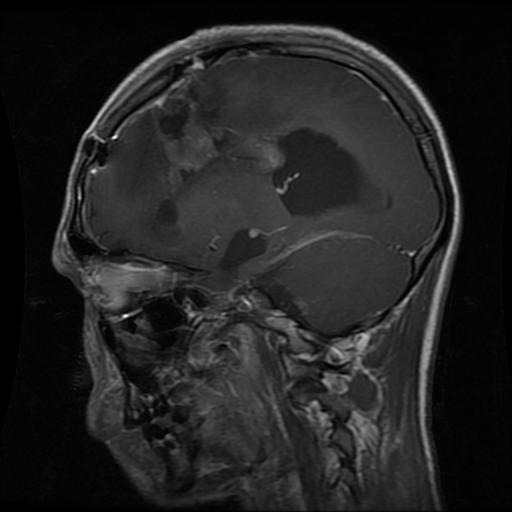

gg (357).jpg


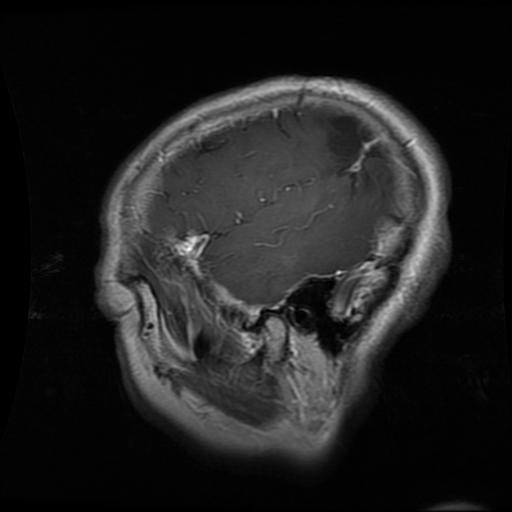

gg (466).jpg


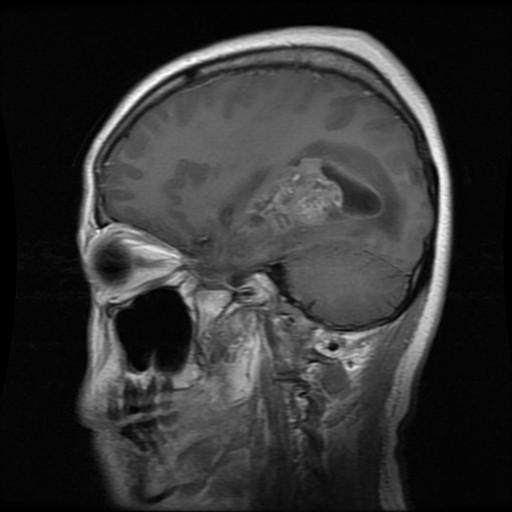

gg (682).jpg


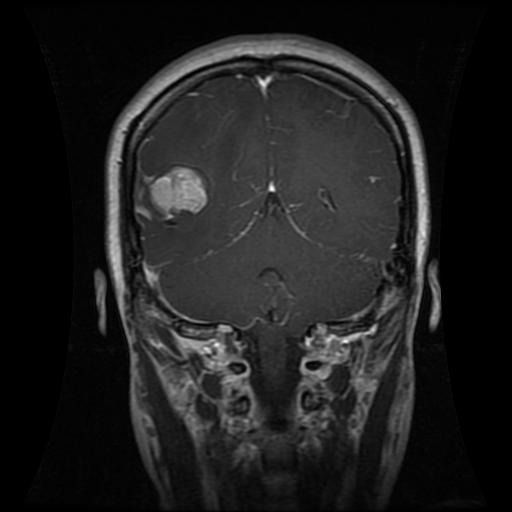

gg (224).jpg


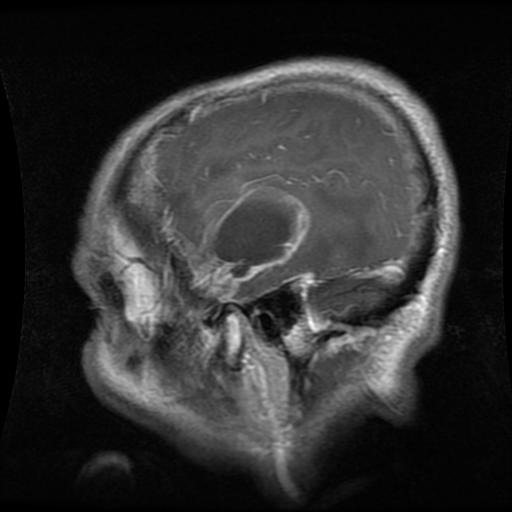

gg (540).jpg


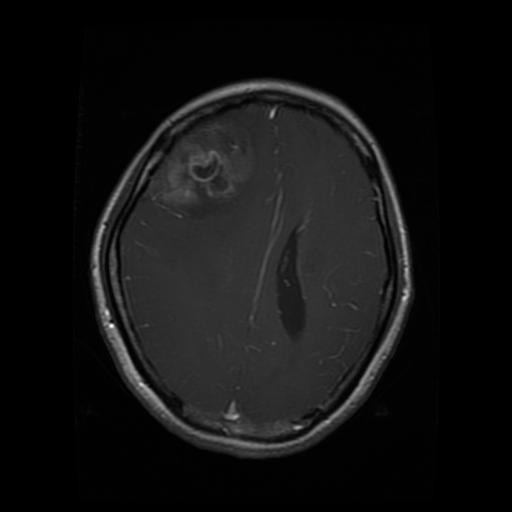

gg (657).jpg


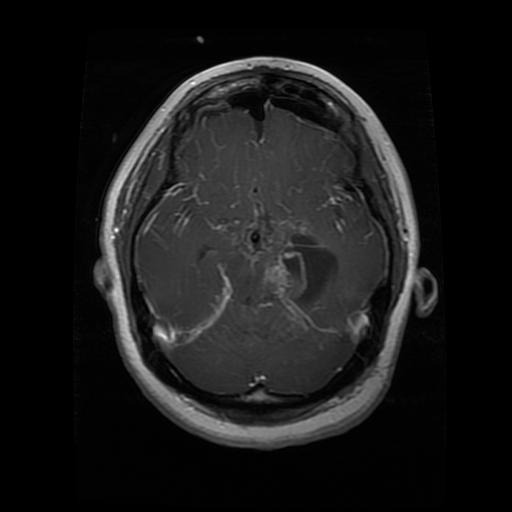

gg (745).jpg


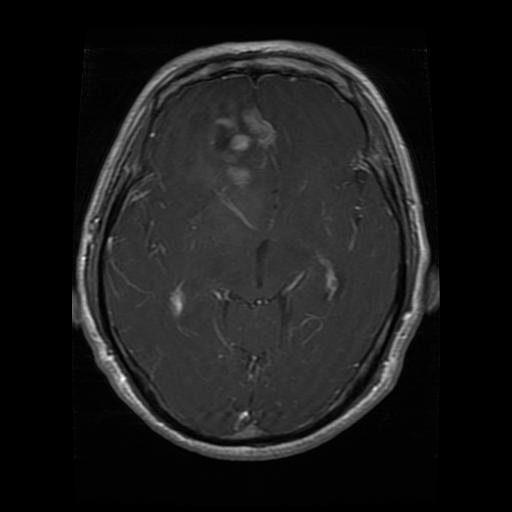

gg (716).jpg


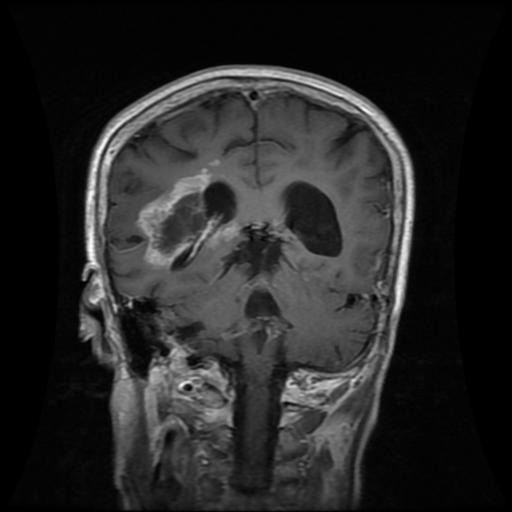

gg (261).jpg


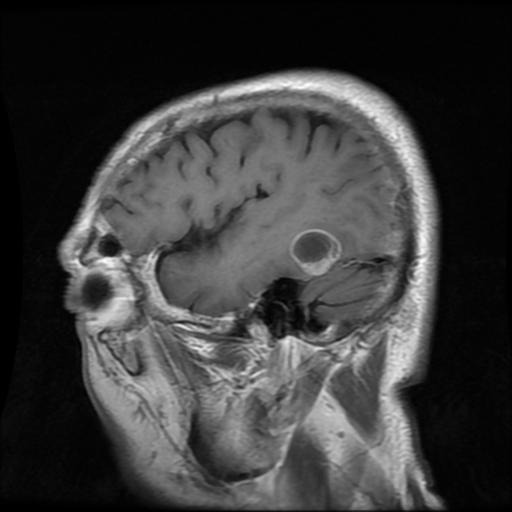

In [7]:
# plot some images

from PIL import Image

folder = train_path + "/glioma_tumor"

gliomafiles = [f for f in os.listdir(folder) if os.path.isfile(os.path.join(folder,f))]

print("working with {} images".format(gliomafiles))
print("Images Example : ")

for i in range(0,10):
  print(gliomafiles[i])
  display(_Imdis(filename = folder + "/"+ gliomafiles[i] ,width = 300,height = 300))

In [8]:
# lets define the image shape for the model

image_shape = [224,224,3]



In [9]:
# lets import the vgg19 model

pre_trained_model  = VGG19(
                    input_shape = (224,224,3),
                    include_top = False,
                    weights = "imagenet"
)


for layer in pre_trained_model.layers[:19]:
  layer.trainable = False


model = Sequential([
    pre_trained_model,
    tf.keras.layers.MaxPool2D((2,2),strides = 2),
    Flatten(),
    # Dense(100,activation = "relu"),
    # Dense(10,activation = "relu"),
    Dense(4,activation = "softmax")
])

model.compile(
              optimizer = "adam",
              loss = tf.keras.losses.CategoricalCrossentropy(),
              metrics = ["accuracy"]
)

80134624/80134624 [==============================] - 3s 0us/step


In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 7, 7, 512)         20024384  
                                                                 
 max_pooling2d (MaxPooling2  (None, 3, 3, 512)         0         
 D)                                                              
                                                                 
 flatten (Flatten)           (None, 4608)              0         
                                                                 
 dense (Dense)               (None, 4)                 18436     
                                                                 
Total params: 20042820 (76.46 MB)
Trainable params: 4738052 (18.07 MB)
Non-trainable params: 15304768 (58.38 MB)
_________________________________________________________________


In [11]:
# preprocessing the dataset

train_datagen = ImageDataGenerator(
                                rescale = 1/225.,
                                rotation_range = 40,
                                shear_range = 0.2,
                                zoom_range = 0.2,
                                horizontal_flip = True,
                                fill_mode = "nearest"
)

test_datagen = ImageDataGenerator(
                                rescale = 1/225.,
                                rotation_range = 40,
                                shear_range = 0.2,
                                zoom_range = 0.2,
                                horizontal_flip = True,
                                fill_mode = "nearest"
)

In [12]:
# pass the data

train_data = train_datagen.flow_from_directory(
                                              train_path,
                                              target_size = (224,224),
                                              batch_size = 32,
                                              class_mode = "categorical"
)

test_data = test_datagen.flow_from_directory(
                                              test_path,
                                              target_size = (224,224),
                                              batch_size = 32,
                                              class_mode = "categorical"
)



Found 2870 images belonging to 4 classes.
Found 394 images belonging to 4 classes.


In [13]:
from datetime import datetime
from keras.callbacks import ModelCheckpoint
from keras.callbacks import ReduceLROnPlateau


learning_rate_reduction = ReduceLROnPlateau(
                                    monitor = "val_accuracy",
                                    patience = 3,
                                    verbose = 1,
                                    factor = 0.6,
                                    min_lr = 0.0001
)

checkpoint = ModelCheckpoint(
    filepath = "vgg19_model.h5",
    verbose = 1,
    save_best_only = True
)

callbacks = [checkpoint,learning_rate_reduction]

start = datetime.now()

history = model.fit(

                    train_data,
                    validation_data = test_data,
                    epochs = 5,
                    batch_size = 32,
                    callbacks = callbacks,
                    verbose = True
)

duration = datetime.now()-start

print("Training is completed")

Epoch 1/5
90/90 [==============================] - ETA: 0s - loss: 1.1229 - accuracy: 0.5401
Epoch 1: val_loss improved from inf to 1.71086, saving model to vgg19_model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


90/90 [==============================] - 72s 640ms/step - loss: 1.1229 - accuracy: 0.5401 - val_loss: 1.7109 - val_accuracy: 0.4239 - lr: 0.0010
Epoch 2/5
90/90 [==============================] - ETA: 0s - loss: 0.6486 - accuracy: 0.7449
Epoch 2: val_loss did not improve from 1.71086
90/90 [==============================] - 49s 540ms/step - loss: 0.6486 - accuracy: 0.7449 - val_loss: 1.7217 - val_accuracy: 0.5635 - lr: 0.0010
Epoch 3/5
90/90 [==============================] - ETA: 0s - loss: 0.5391 - accuracy: 0.7944
Epoch 3: val_loss did not improve from 1.71086
90/90 [==============================] - 48s 533ms/step - loss: 0.5391 - accuracy: 0.7944 - val_loss: 1.8968 - val_accuracy: 0.5482 - lr: 0.0010
Epoch 4/5
90/90 [==============================] - ETA: 0s - loss: 0.4380 - accuracy: 0.8265
Epoch 4: val_loss improved from 1.71086 to 1.64574, saving model to vgg19_model.h5
90/90 [==============================] - 53s 588ms/step - loss: 0.4380 - accuracy: 0.8265 - val_loss: 1.6457 